# Guided Example: Applying the DeepDynamics Framework to Integrated sc/snRNA-seq and Deconvolved Bulk RNA-seq Data

This notebook provides a step-by-step example of how to use the DeepDynamics framework. It is designed for users working with well-annotated single-cell or single-nucleus RNA-seq data, alongside matched deconvolved bulk RNA-seq data.


## Imports

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt

from prediction.training import *

## Data Preprocess - Example
This section is parllel to the prediction.preprocess.py script

In [ ]:
# single cell data
data = sc.read_h5ad("./prediction/data/500.h5ad")
data

In [ ]:
id_train = data.uns['celmod']['avg.predicted.prop']['train'].index.astype(int)
id_train = id_train.sort_values()

In [ ]:
id_shared = data.uns['celmod']['shared.donors'].astype(int)
id_shared.sort()

In [ ]:
assert np.array_equal(id_shared, id_train)

In [ ]:
print(data.uns['celmod']['avg.predicted.prop']['train'].shape)
data.uns['celmod']['avg.predicted.prop']['train'].head() # This is the shared bulk and SC patients.

(419, 91)


,Arteriole,Ast.1,Ast.10,Ast.2,Ast.3,Ast.4,Ast.5,Ast.6,Ast.7,Ast.8,...,Oli.8,Oli.9,OPC.1,OPC.2,OPC.3,Peri.1,Peri.2,SMC.1,SMC.2,Venule
10100574,0.295130,0.208606,0.154027,0.230224,0.111938,0.333699,0.434980,0.419568,0.594114,0.139232,...,0.139095,0.084217,0.309182,0.773902,0.486993,0.155990,0.177164,0.244676,0.263565,0.309723
10100736,0.271269,0.590092,0.067591,0.144527,0.452008,0.512295,0.284409,0.108491,0.193214,0.099566,...,0.059047,0.098437,0.570738,0.768130,0.232458,0.315589,0.150155,0.409364,0.304621,0.237793
10100862,0.293022,0.507955,0.043077,0.472956,0.167850,0.444572,0.127339,0.276681,0.414916,0.157957,...,0.035891,0.123602,0.322432,0.893485,0.102633,0.051987,0.310193,0.293736,0.250961,0.256000
10101327,0.135468,0.536871,0.345134,0.479327,0.477574,0.316794,0.010520,0.112717,0.102534,0.098586,...,0.015757,0.171146,0.545249,0.805265,0.005905,0.024754,0.478433,0.281611,0.067436,0.067913
10101589,0.225293,0.586473,0.032397,0.395555,0.283454,0.505767,0.153095,0.125258,0.314925,0.155001,...,0.004580,0.168632,0.575824,0.768905,0.186589,0.280220,0.124628,0.310999,0.278974,0.261841


In [ ]:
data.uns['celmod']['shared.donors'][:5]  # This is only the bulk X single cell shared patients.

array(['11395417', '20214850', '20416210', '20963578', '50302004'],
      dtype=object)

In [ ]:
# Filtering to only the most confident cell states (68)
cell_corr_data = data.uns['celmod']['test.corrs']
cell_state_filter = cell_corr_data.index[(cell_corr_data['adj.pval'] < 0.005) & (cell_corr_data['corr'] > 0)]
cell_state_filter.shape

(58,)

In [ ]:
# This is the bulk samples that also appears on the single cell data and filtered cell types
shared_bulk_data = data.uns['celmod']['avg.predicted.prop']['train'][cell_state_filter]
print(shared_bulk_data.shape)
shared_bulk_data.head()

(419, 58)


,Ast.1,Ast.10,Ast.2,Ast.3,Ast.4,Ast.5,Ast.6,Ast.7,Ast.8,Ast.9,...,Oli.5,Oli.7,Oli.8,Oli.9,OPC.1,OPC.2,OPC.3,Peri.1,Peri.2,Venule
10100574,0.208606,0.154027,0.230224,0.111938,0.333699,0.434980,0.419568,0.594114,0.139232,0.135164,...,0.073293,0.112277,0.139095,0.084217,0.309182,0.773902,0.486993,0.155990,0.177164,0.309723
10100736,0.590092,0.067591,0.144527,0.452008,0.512295,0.284409,0.108491,0.193214,0.099566,0.140264,...,0.255475,0.065736,0.059047,0.098437,0.570738,0.768130,0.232458,0.315589,0.150155,0.237793
10100862,0.507955,0.043077,0.472956,0.167850,0.444572,0.127339,0.276681,0.414916,0.157957,0.027326,...,0.083430,0.023109,0.035891,0.123602,0.322432,0.893485,0.102633,0.051987,0.310193,0.256000
10101327,0.536871,0.345134,0.479327,0.477574,0.316794,0.010520,0.112717,0.102534,0.098586,0.037603,...,0.241934,0.262418,0.015757,0.171146,0.545249,0.805265,0.005905,0.024754,0.478433,0.067913
10101589,0.586473,0.032397,0.395555,0.283454,0.505767,0.153095,0.125258,0.314925,0.155001,0.007700,...,0.063644,0.013174,0.004580,0.168632,0.575824,0.768905,0.186589,0.280220,0.124628,0.261841


In [ ]:
X = data.layers['sqrt.prev'] # single cell data

In [ ]:
features_names = shared_bulk_data.columns

In [ ]:
# first response vector, this is the probability of each sample to be part of the W/S branch
# y1 = data.uns['trajectories']['branch.probs'] # OLD
y1 = data.uns['trajectories']['palantir']['branch.probs'] # NEW
# second response vector, this is the psuedotime of each sample
# y2 = data.uns['trajectories']['pseudotime'] # OLD
y2 = data.uns['trajectories']['palantir']['pseudotime'] # NEW
y2[:5]

array([0.57158684, 0.24037285, 0.1535378 , 0.08210509,        nan])

In [ ]:
mask = ~np.isnan(y2)
X_mask = X[mask]
y1_mask = y1[mask]
y2_mask = y2[mask]
print("Sainty check, num of null values: ",sum(np.isnan(y2_mask)))
print(X.shape, X_mask.shape)

Sainty check, num of null values:  0
(437, 91) (386, 91)


In [ ]:
# adding ID's as index for y2
print(y1_mask.shape)
y2_mask = pd.DataFrame(y2_mask)
y2_mask.index = y1_mask.index
y2_mask.rename(columns = {0:'Pseudotime'}, inplace=True)

(386, 2)


In [ ]:
IDs = y2_mask.index # This is the none null patients.
# filtering out of the valid patients the shared patients.
mask = []
for id in shared_bulk_data.index:
    if id in IDs:
        mask.append(id)

shared_bulk_data_mask = shared_bulk_data.loc[mask]
print(shared_bulk_data.shape, shared_bulk_data_mask.shape) # sanity check

(419, 58) (371, 58)


In [ ]:
# filtering the results vectors
new_y1_mask = y1.loc[mask]
new_y2_mask = pd.DataFrame(y2_mask).loc[mask]
print("Sainty check, num of null values: ", sum(np.isnan(new_y2_mask).astype(int)['Pseudotime']))
print(new_y1_mask.shape, new_y2_mask.shape)

Sainty check, num of null values:  0
(371, 2) (371, 1)


In [ ]:
new_y1_mask['psuedotime'] = new_y2_mask
y_mask = new_y1_mask
print(y_mask.shape)
y_mask.head()

(371, 3)


,prAD,ABA,psuedotime
10100574,0.386358,0.613642,0.125280
10100736,0.000000,0.999928,0.571587
10100862,0.481352,0.518648,0.026123
10101327,0.997565,0.000000,0.249342
10101589,0.505792,0.494208,0.082858


## Data Loading

In [ ]:
shared_bulk_data_mask = pd.read_csv('./prediction/data/shared_bulk_data_0.005.csv', index_col=0)
y_mask = pd.read_csv('./prediction/data/shared_bulk_target_0.005.csv', index_col=0)
input_size = shared_bulk_data_mask.shape[1]
shared_bulk_data_mask.shape

(371, 58)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(shared_bulk_data_mask, y_mask, test_size=0.25, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_data = SCData(X_train_tensor, y_train_tensor)
test_data = SCData(X_test_tensor, y_test_tensor)

## Training & Evaluation

#### Model settings

In [ ]:
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

config = {"l1_lambda": 0,
        "l2_lambda": 0.,
        }
model = ProbModel()
loss_func = ProbLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
epochs = 2000

In [ ]:
train_loss, test_loss, kl_train_loss_list, ce_train_loss_list, kl_test_loss_list, ce_test_loss_list, time_train_loss_list, time_test_loss_list = train_model(model, optimizer, train_loader, test_loader, epochs, loss_func, patience=10, config=config)

Epoch 10: Train Loss = 1.461, Test Loss = 1.567
Epoch 20: Train Loss = 1.430, Test Loss = 1.533
Epoch 30: Train Loss = 1.386, Test Loss = 1.484
Epoch 40: Train Loss = 1.334, Test Loss = 1.421
Epoch 50: Train Loss = 1.268, Test Loss = 1.345
Epoch 60: Train Loss = 1.190, Test Loss = 1.255
Epoch 70: Train Loss = 1.105, Test Loss = 1.158
Epoch 80: Train Loss = 1.024, Test Loss = 1.064
Epoch 90: Train Loss = 0.954, Test Loss = 0.986
Epoch 100: Train Loss = 0.897, Test Loss = 0.925
Epoch 110: Train Loss = 0.856, Test Loss = 0.879
Epoch 120: Train Loss = 0.826, Test Loss = 0.846
Epoch 130: Train Loss = 0.802, Test Loss = 0.818
Epoch 140: Train Loss = 0.781, Test Loss = 0.798
Epoch 150: Train Loss = 0.768, Test Loss = 0.782
Epoch 160: Train Loss = 0.756, Test Loss = 0.770
Epoch 170: Train Loss = 0.745, Test Loss = 0.759
Epoch 180: Train Loss = 0.736, Test Loss = 0.751
Epoch 190: Train Loss = 0.728, Test Loss = 0.744
Epoch 200: Train Loss = 0.723, Test Loss = 0.738
Epoch 210: Train Loss = 0.716

In [ ]:
model_thin = ProbModelThin()
optimizer = optim.Adam(model_thin.parameters(), lr=1e-4)#, weight_decay=1e-5)
epochs = 2000
train_loss_thin, test_loss_thin, kl_train_loss_list_thin, ce_train_loss_list_thin, kl_test_loss_list_thin, ce_test_loss_list_thin, time_train_loss_list_thin, time_test_loss_list_thin = train_model(model_thin, optimizer, train_loader, test_loader, epochs, loss_func, patience=10, config=config)

Epoch 10: Train Loss = 1.164, Test Loss = 1.220
Epoch 20: Train Loss = 0.955, Test Loss = 0.990
Epoch 30: Train Loss = 0.834, Test Loss = 0.860
Epoch 40: Train Loss = 0.775, Test Loss = 0.796
Epoch 50: Train Loss = 0.736, Test Loss = 0.763
Epoch 60: Train Loss = 0.715, Test Loss = 0.743
Epoch 70: Train Loss = 0.700, Test Loss = 0.729
Epoch 80: Train Loss = 0.686, Test Loss = 0.720
Epoch 90: Train Loss = 0.677, Test Loss = 0.714
Epoch 100: Train Loss = 0.667, Test Loss = 0.707
Epoch 110: Train Loss = 0.660, Test Loss = 0.702
Epoch 120: Train Loss = 0.652, Test Loss = 0.700
Epoch 130: Train Loss = 0.646, Test Loss = 0.695
Epoch 140: Train Loss = 0.641, Test Loss = 0.691
Epoch 150: Train Loss = 0.634, Test Loss = 0.689
Epoch 160: Train Loss = 0.631, Test Loss = 0.683
Epoch 170: Train Loss = 0.624, Test Loss = 0.682
Epoch 180: Train Loss = 0.620, Test Loss = 0.682
Epoch 190: Train Loss = 0.617, Test Loss = 0.678
Epoch 200: Train Loss = 0.615, Test Loss = 0.676
Epoch 210: Train Loss = 0.610

In [ ]:
save = False
if save:
    torch.save(model_thin.state_dict(), 'weights/model_thin.pth')
    torch.save(model.state_dict(), 'weights/model.pth')

## Visualization

In [ ]:
def plot_losses(train_loss, test_loss, kl_train_loss_list, ce_train_loss_list, kl_test_loss_list, ce_test_loss_list, time_train_loss_list, time_test_loss_list):
  epoch_index = np.arange(1, len(train_loss) + 1)
  plt.plot(epoch_index, train_loss, c='b', label='Train Loss')
  plt.plot(epoch_index, test_loss, c='r', label='Test Loss')
  plt.legend()
  plt.title('Loss Per Epoch')
  plt.show()

  plt.plot(epoch_index, kl_train_loss_list, c='b', label='KL Train Loss')
  plt.plot(epoch_index, kl_test_loss_list, c='r', label='KL Test Loss')
  plt.legend()
  plt.title('KL Loss Per Epoch')
  plt.show()

  plt.plot(epoch_index, ce_train_loss_list, c='b', label='CE Train Loss')
  plt.plot(epoch_index, ce_test_loss_list, c='r', label='CE Test Loss')
  plt.legend()
  plt.title('CE Loss Per Epoch')
  plt.show()

  plt.plot(epoch_index, time_train_loss_list, c='b', label='MSE Train Loss')
  plt.plot(epoch_index, time_test_loss_list, c='r', label='MSE Test Loss')
  plt.legend()
  plt.title('Psuedotime Loss Per Epoch')

  plt.show()



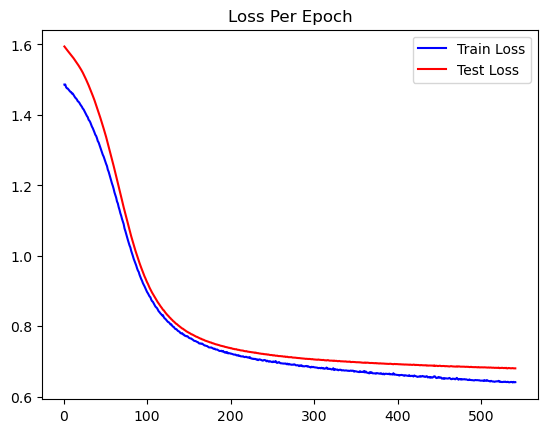

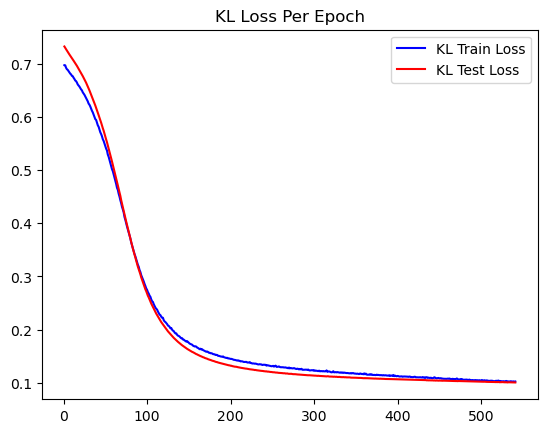

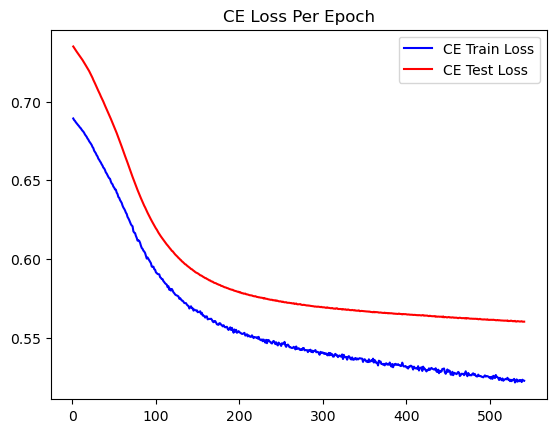

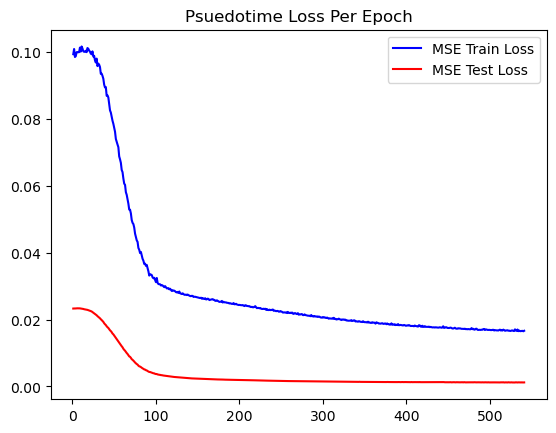

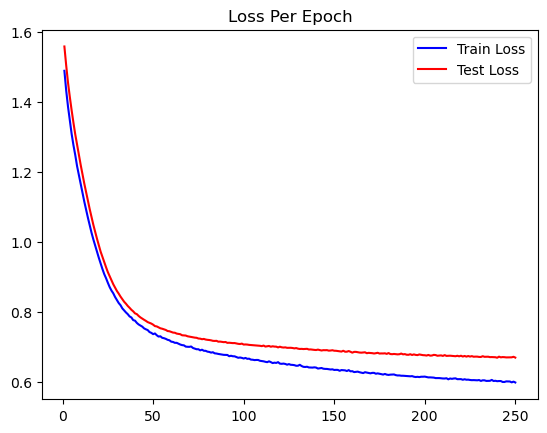

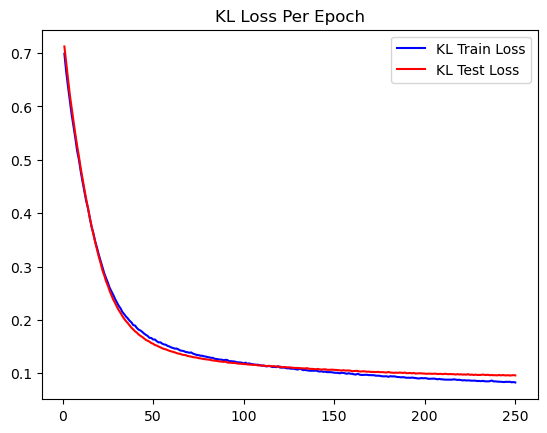

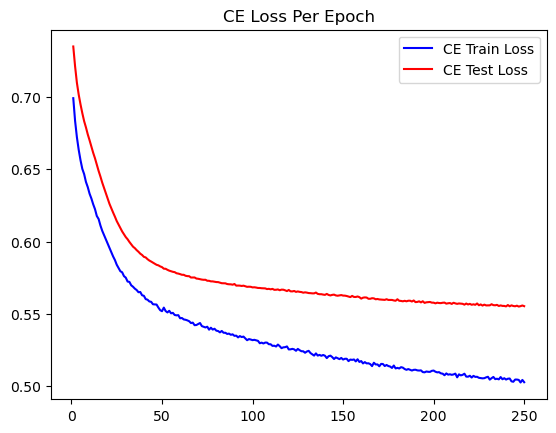

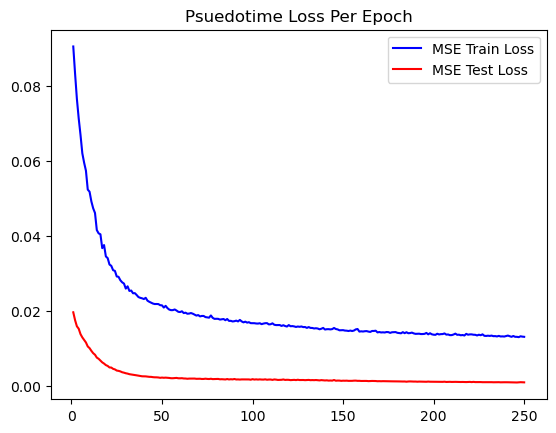

In [ ]:
plot_losses(train_loss, test_loss, kl_train_loss_list, ce_train_loss_list, kl_test_loss_list, ce_test_loss_list, time_train_loss_list, time_test_loss_list)
plot_losses(train_loss_thin, test_loss_thin, kl_train_loss_list_thin, ce_train_loss_list_thin, kl_test_loss_list_thin, ce_test_loss_list_thin, time_train_loss_list_thin, time_test_loss_list_thin)

### Phate Error Visualization

I want to see the error for each individual point. So I will plot the phate results and color code the points based on their CE error



In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def plot_phate_colored_by_error(locations, error, title, label_title):
  plt.figure(figsize=(5, 3))
  ax = plt.gca()
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
  plt.scatter(x=locations[0], y=locations[1],
              c=error, s=10, label=label_title, alpha=0.5, vmin=0, vmax=1)
  plt.title(title)
  plt.colorbar()
  plt.legend()
  plt.show()


In [ ]:
data = sc.read_h5ad("prediction/data/500.h5ad")
locations = pd.DataFrame(data.obsm['X_core_phate'])
locations.index = y1.index

In [ ]:
locations.index = locations.index.astype(int)
train_locations = locations.loc[y_train.index].values.T
test_locations = locations.loc[y_test.index].values.T

In [ ]:
ce_loss_vector = nn.CrossEntropyLoss(reduction='none')
train_pred = model(X_train_tensor)
test_pred = model(X_test_tensor)
train_ce_error = ce_loss_vector(train_pred[:, :2], y_train_tensor[:, :2]).detach().numpy()
test_ce_error = ce_loss_vector(test_pred[:, :2], y_test_tensor[:, :2]).detach().numpy()

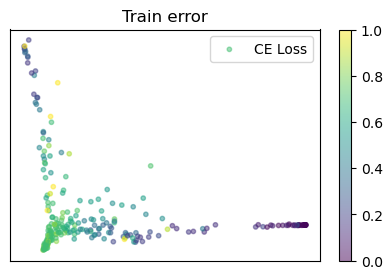

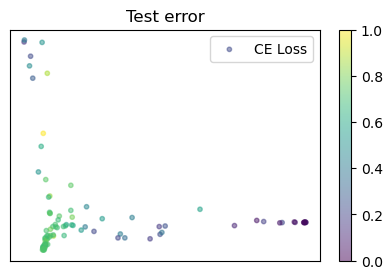

In [ ]:
plot_phate_colored_by_error(train_locations, train_ce_error, 'Train error', 'CE Loss')
plot_phate_colored_by_error(test_locations, test_ce_error, 'Test error', 'CE Loss')

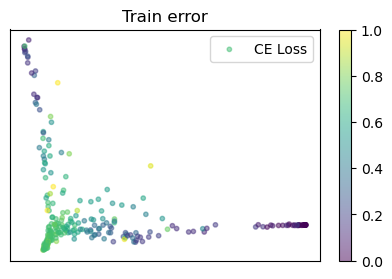

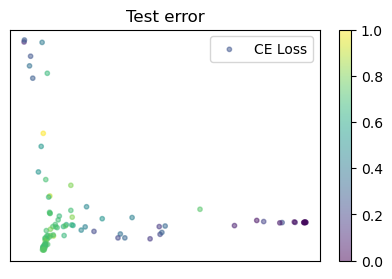

In [ ]:
train_pred = model_thin(X_train_tensor)
test_pred = model_thin(X_test_tensor)
train_ce_error = ce_loss_vector(train_pred[:, :2], y_train_tensor[:, :2]).detach().numpy()
test_ce_error = ce_loss_vector(test_pred[:, :2], y_test_tensor[:, :2]).detach().numpy()
plot_phate_colored_by_error(train_locations, train_ce_error, 'Train error', 'CE Loss')
plot_phate_colored_by_error(test_locations, test_ce_error, 'Test error', 'CE Loss')

### Psuedotime visualization

In [ ]:
def plot_psuedotime(pred, real, title):
  samples = np.linspace(0, 1, len(real))
  mse_score = np.mean((pred - real) ** 2)
  # mae_score = np.abs((pred - real)).sum()

  plt.figure(figsize=(7, 5))
  plt.scatter(pred, real, s=10)
  plt.plot(samples,samples, color='red', linestyle='--', label='True == predicted')
  plt.xlabel('Prediction')
  plt.ylabel('True Values')
  plt.title(title)
  plt.text(0., 0.8, f'MSE: {mse_score:.4f}',fontsize=14, color='black', bbox=dict(facecolor='yellow', alpha=0.5))
  # plt.text(0., 0.8, f'MAE: {mae_score:.4f}',fontsize=14, color='black', bbox=dict(facecolor='yellow', alpha=0.5))

  plt.legend()
  plt.show()

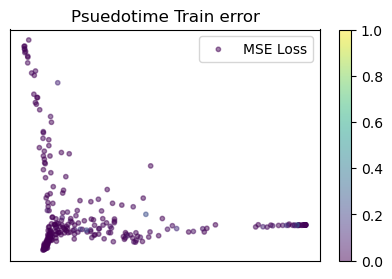

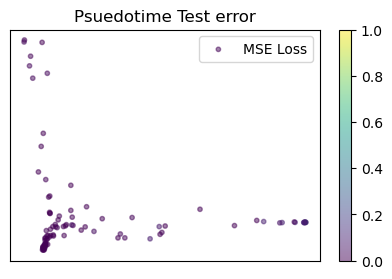

In [ ]:
mse_loss_vector = nn.MSELoss(reduction='none')
train_pred = model(X_train_tensor)
test_pred = model(X_test_tensor)
train_ce_error = mse_loss_vector(train_pred[:, 2], y_train_tensor[:, 2]).detach().numpy()
test_ce_error = mse_loss_vector(test_pred[:, 2], y_test_tensor[:, 2]).detach().numpy()

plot_phate_colored_by_error(train_locations, train_ce_error, 'Psuedotime Train error', 'MSE Loss')
plot_phate_colored_by_error(test_locations, test_ce_error, 'Psuedotime Test error', 'MSE Loss')

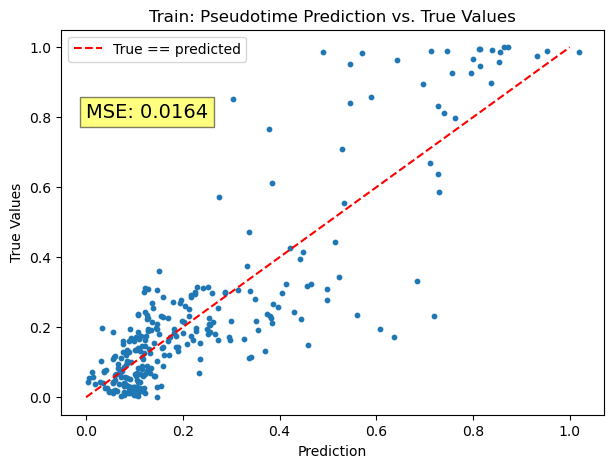

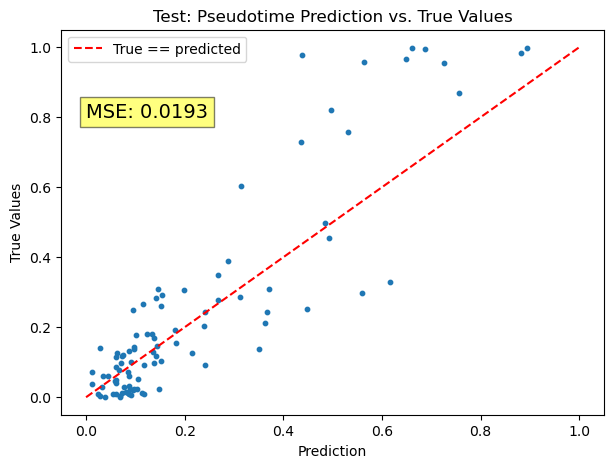

In [ ]:
train_pred = model(X_train_tensor).detach().numpy()
test_pred = model(X_test_tensor).detach().numpy()
plot_psuedotime(train_pred[:, 2], y_train['psuedotime'], 'Train: Pseudotime Prediction vs. True Values')
plot_psuedotime(test_pred[:, 2], y_test['psuedotime'], 'Test: Pseudotime Prediction vs. True Values')

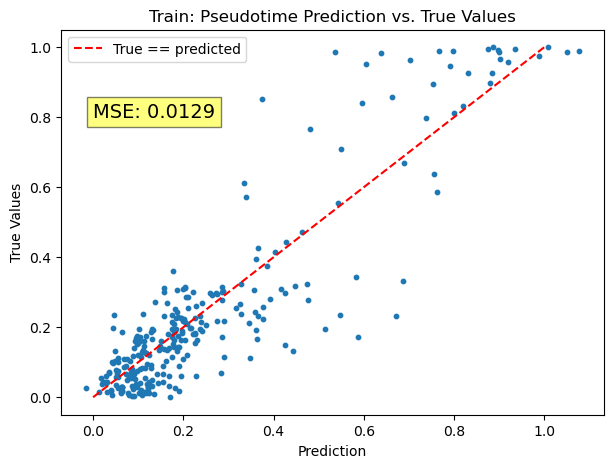

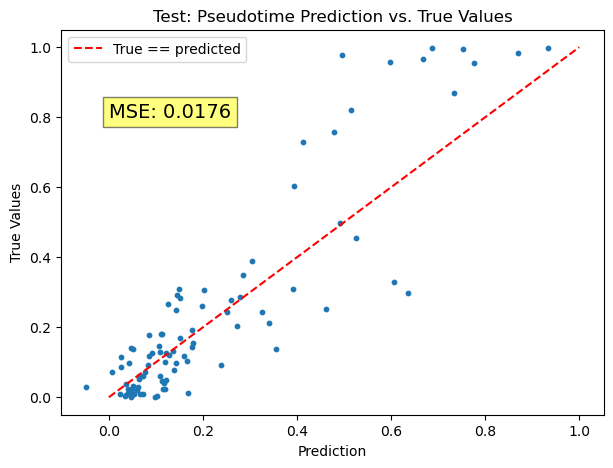

In [ ]:
train_pred = model_thin(X_train_tensor).detach().numpy()
test_pred = model_thin(X_test_tensor).detach().numpy()
plot_psuedotime(train_pred[:, 2], y_train['psuedotime'], 'Train: Pseudotime Prediction vs. True Values')
plot_psuedotime(test_pred[:, 2], y_test['psuedotime'], 'Test: Pseudotime Prediction vs. True Values')

## Bootstrap results

In [ ]:
from tqdm import tqdm

In [ ]:
bs_train_loss, bs_test_loss, bs_kl_train, bs_kl_test, bs_ce_train, bs_ce_test, bs_time_train, bs_time_test = [], [], [], [], [], [], [], []
loss_func = ProbLoss()
for i in tqdm(range(100)):
  torch.random.seed = 42
  X_train, X_test, y_train, y_test = train_test_split(shared_bulk_data_mask, y_mask, test_size=0.25, random_state=i)

  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
  train_data = SCData(X_train_tensor, y_train_tensor)
  test_data = SCData(X_test_tensor, y_test_tensor)

  batch_size = 15
  train_loader = DataLoader(train_data, batch_size=batch_size)
  test_loader = DataLoader(test_data, batch_size=batch_size)

  model = ProbModel()
  optimizer = optim.Adam(model.parameters())
  epochs = 150
  train_loss, test_loss, kl_train_loss_list, ce_train_loss_list, kl_test_loss_list, ce_test_loss_list, time_train_loss_list, time_test_loss_list = train_model(model, optimizer,
                                                                                                                    train_loader, test_loader,
                                                                                                                    epochs, loss_func, print_progress=False, early_stopping=False, config=config)

  bs_train_loss.append(np.array(train_loss))
  bs_test_loss.append(np.array(test_loss))
  bs_kl_train.append(np.array(kl_train_loss_list))
  bs_kl_test.append(np.array(kl_test_loss_list))
  bs_ce_train.append(np.array(ce_train_loss_list))
  bs_ce_test.append(np.array(ce_test_loss_list))
  bs_time_train.append(time_train_loss_list)
  bs_time_test.append(time_test_loss_list)

100%|██████████| 100/100 [11:31<00:00,  6.91s/it]


In [ ]:
def plot_bootstrap(bootstrap_data, title):
  lower, upper = np.percentile(bootstrap_data, [2.5, 97.5], axis=0)
  plt.plot(bootstrap_data.mean(axis=0))
  plt.plot(lower, color='red', linestyle='--')
  plt.plot(upper, color='red', linestyle='--')
  plt.fill_between(range(len(bootstrap_data.mean(axis=0))), lower, upper, color='gray', alpha=0.2)
  plt.title(title)
  plt.savefig(f'prediction/figures/{title}.pdf')
  plt.show()

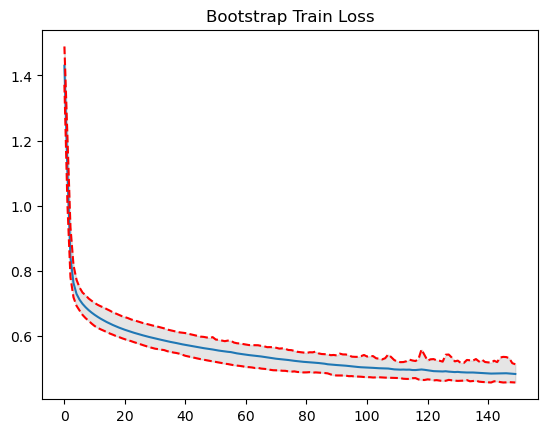

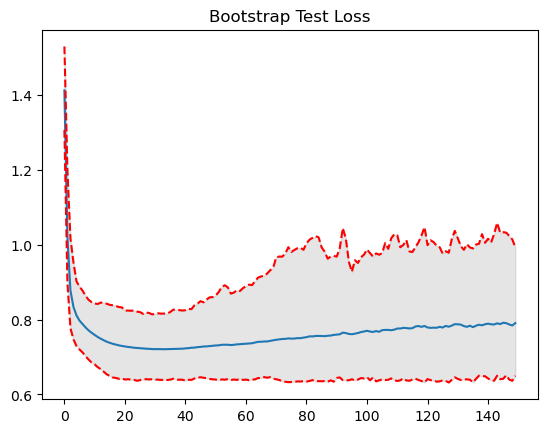

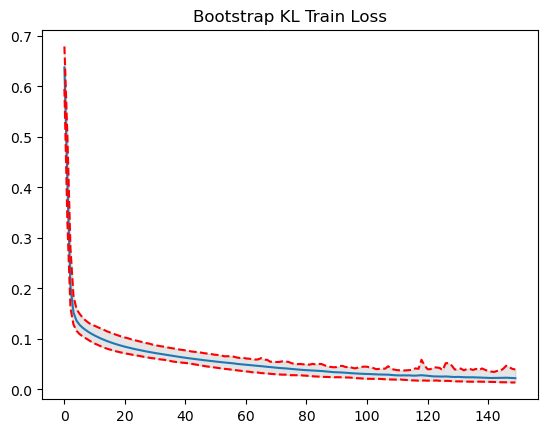

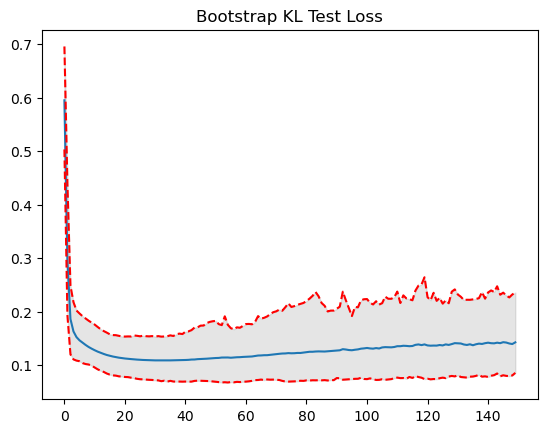

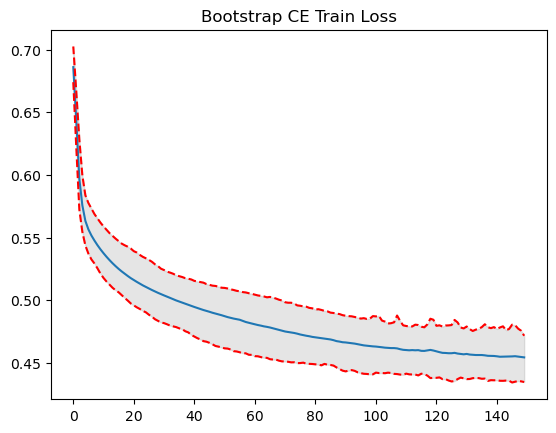

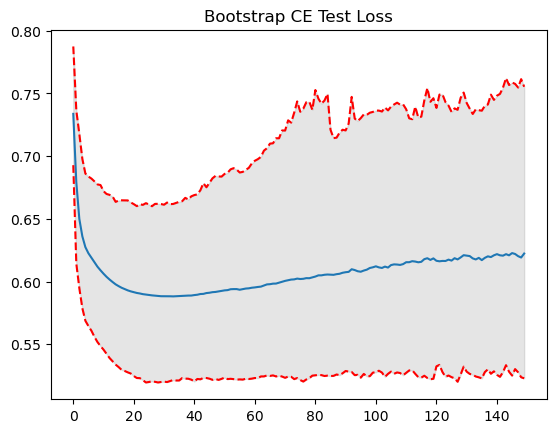

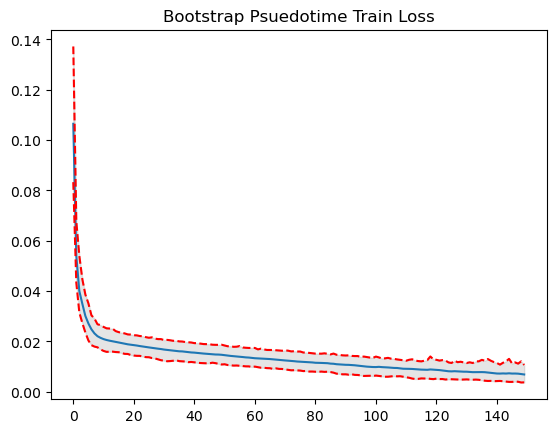

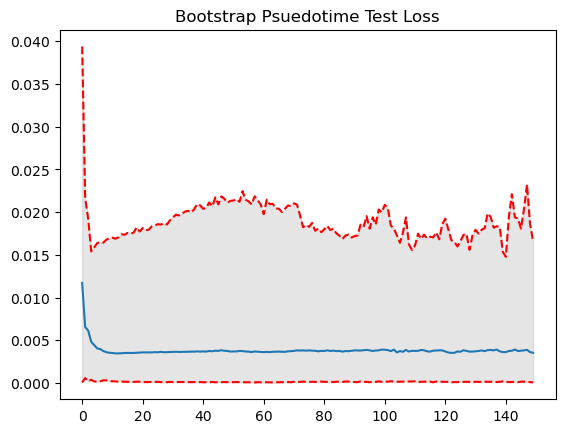

In [ ]:
plot_bootstrap(np.array(bs_train_loss), 'Bootstrap Train Loss')
plot_bootstrap(np.array(bs_test_loss), 'Bootstrap Test Loss')
plot_bootstrap(np.array(bs_kl_train), 'Bootstrap KL Train Loss')
plot_bootstrap(np.array(bs_kl_test), 'Bootstrap KL Test Loss')
plot_bootstrap(np.array(bs_ce_train), 'Bootstrap CE Train Loss')
plot_bootstrap(np.array(bs_ce_test), 'Bootstrap CE Test Loss')
plot_bootstrap(np.array(bs_time_train), 'Bootstrap Psuedotime Train Loss')
plot_bootstrap(np.array(bs_time_test), 'Bootstrap Psuedotime Test Loss')

## Model Explainability

In [ ]:
import shap

/ems/elsc-labs/habib-n/yuval.rom/miniconda3/envs/deepdynamics/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X = pd.concat((X_train, X_test))

In [ ]:
# This is the bulk samples that do not appears on the single cell data, with filtered cell types
unshared_bulk_data = data.uns['celmod']['avg.predicted.prop']['validation'][cell_state_filter]
unshared_bulk_data.shape

(673, 58)

In [ ]:
all_bulk_data = pd.concat((shared_bulk_data, unshared_bulk_data))
all_bulk_data.shape

(1092, 58)

In [ ]:
# define a wrapper function for the model that takes a NumPy array as input
shap.initjs()
def model_wrapper(x):
    x_tensor = torch.tensor(x).float()
    y_pred = model_thin(x_tensor)
    return y_pred.detach().numpy()


# create a SHAP explainer object
explainer = shap.KernelExplainer(model_wrapper, all_bulk_data)

# generate SHAP values for the first test example
shap_values = explainer.shap_values(all_bulk_data.values[0:,:])

titles = ['prAD', 'ABA', 'Pseudotime']
for i in range(len(shap_values)):
    plt.title(f'All Bulk Samples {titles[i]}')
    shap.summary_plot(shap_values[i], all_bulk_data, plot_type='dot', title=f'Output {i+1}', feature_names=all_bulk_data.columns)

## Final prediction and saving results

In [ ]:
pred = model.predict(torch.tensor(all_bulk_data.values, dtype=torch.float32)).detach().numpy()
df = pd.DataFrame({'prAD': pred[:, 0],
                   'ABA': pred[:, 1],
                   'psuedotime': pred[:, 2]})
df.index = all_bulk_data.index
df.to_csv('prediction/data/all_bulk_data_prediction.csv')

In [ ]:
df.head()